### `list_attr_celeba` Dataset
A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).



- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image

You can obtain the dataset from https://www.kaggle.com/jessicali9530/celeba-dataset

In [82]:
import numpy as np
import pandas as pd 

from PIL import UnidentifiedImageError
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import random
import tensorflow as tf
import os
import shutil
import cv2

import keras
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator #, image
from keras.utils import load_img
from keras.utils import to_categorical
from keras.models import Model
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
from keras.applications.xception import Xception 
from keras.applications.xception import preprocess_input

from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [14]:
#set a seed
SEED = 1
np.random.seed(SEED)
random.set_seed(SEED)

In [49]:
DATADIR = r'D:\Study 2018 and later\Mignimind Bootcamp\Code\P5-WarmUp\Data for all Projects\celeb_small' 
CATEGORIES = ["Man", "Female"]

In [39]:
def check_images(datadir, delete=False):
    badfiles = 0
    for dirobject in os.scandir(datadir):
        if dirobject.is_file():
            try:
                load_img(dirobject.path)
            except UnidentifiedImageError:
                badfiles = + 1
                if delete:
                    print("Removing: ", dirobject.path)
                    os.remove(dirobject.path)
                else:
                    print("Bad file: ", dirobject.path)
                pass
    if badfiles == 0:
        print('All images are good!')

In [33]:
check_images(DATADIR, delete=True)

Removing:  D:\Study 2018 and later\Mignimind Bootcamp\Code\P5-WarmUp\Data for all Projects\celeb_small\Icon_


In [40]:
check_images(DATADIR)

All images are good!


In [44]:
# Check if we need to resize the images
need_resize = 0
for dirobject in os.scandir(DATADIR):
    if dirobject.is_file():
        img = load_img(dirobject.path)
        if not img.size == (178, 218):
            print(f'Image {dirobject.path} has size {img.size}')
            need_resize = + 1 
if need_resize == 0:
    print('All images have size (178, 218)')

All images have size (178, 218)


#### See sample image

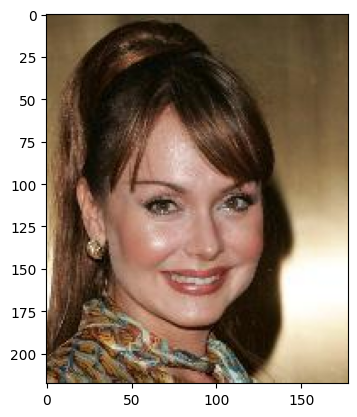

In [46]:
for dirobject in os.scandir(DATADIR):
    if dirobject.is_file():
        img = load_img(dirobject.path)
        plt.imshow(img)
        break

### 4. Build Model

- First, copy VGG16 without the dense layers, use the weights from `imagenet`. Set the input shape to `(178,218,3)`.
- Freeze the layers except the last two layers and print to see if the layers are trainable or not.
- Build your sequential model (you are free to use a functioanl API as a further exercise). Include all the frozen VGG layers to your model. Add a Dense layer with 128 inouts and `relu` activation. Add a batch nomalizer, then a dense layer as the output layer. 
- Create an early stopping criteria monitorin the loss value for the validation set. Stop the search if the loss value deosnt change for two consecutive times.
- Compile the model.
- Save the best model automatically based on the performance of the validation set.

In [51]:
pre_trained_model = Xception(input_shape=(178, 218, 3), include_top=False, weights='imagenet')

In [54]:
for layer in pre_trained_model.layers[-2:]:
    layer.trainable = False

pre_trained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 178, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 88, 108, 32)  864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 88, 108, 32)  128        ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [57]:
pre_trained_model.layers[-3].name

'block14_sepconv2'

In [61]:
layer_to_start = pre_trained_model.get_layer(pre_trained_model.layers[-3].name)

layer_to_start_output = layer_to_start.output

layers_out = Flatten()(layer_to_start_output)
layers_out = Dense(128, activation='relu')(layers_out)
layers_out = BatchNormalization()(layers_out)
layers_out = Dense(1, activation='sigmoid')(layers_out)

earlystop = EarlyStopping(  patience=2,         # Number of epochs with no improvement after which training will be stopped.
                            monitor="val_loss", # Quantity to be monitored.
                            verbose=1)
                            
model = Model(pre_trained_model.input, layers_out)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 5. Data Preparation

- Create a validation set with 20% of the data. Check the number of data points per class from both the train and validation sets.
- Set your batch size to 20.
- Create the data generator and set the `preprocessing_function` to `preprocess_input` of VGG16.
- Create train and validation data generators (batches will be picked up from the dataframe). Set target size to (178,218) (you can try something else, but you need to do the corresponding change in the model).
- Set your validation  and epoch step size (`validation_steps` and `steps_per_epoch`)

In [62]:
categories = []
filenames = []

for dirobject in os.scandir(DATADIR):
    if dirobject.is_file():
        filenames.append(dirobject.name)

        category = dirobject.name.split('.')[0]
        if category == 'female':
            categories.append('Female')
        else:
            categories.append('Man')

df = pd.DataFrame({ 'filename': filenames, 'category': categories})
df

,filename,category
0,female.000009.jpg,Female
1,female.000031.jpg,Female
2,female.000093.jpg,Female
3,female.000142.jpg,Female
4,female.000148.jpg,Female
...,...,...
3796,man.047676.jpg,Man
3797,man.047686.jpg,Man
3798,man.047687.jpg,Man
3799,man.047690.jpg,Man


In [88]:
shutil.rmtree(os.path.join(DATADIR, 'train'), ignore_errors=True)
shutil.rmtree(os.path.join(DATADIR, 'validation'), ignore_errors=True)


os.mkdir(os.path.join(DATADIR, 'train'))
os.mkdir(os.path.join(DATADIR, 'validation'))

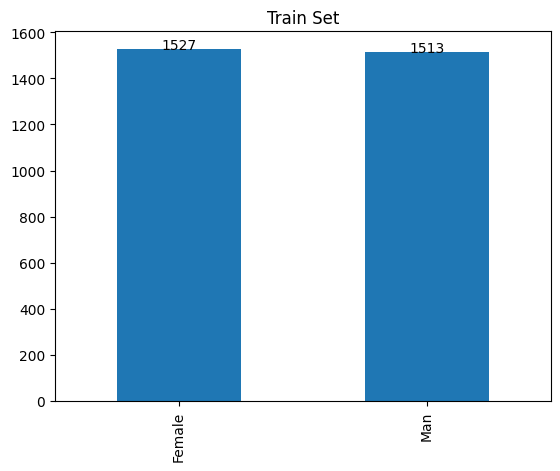

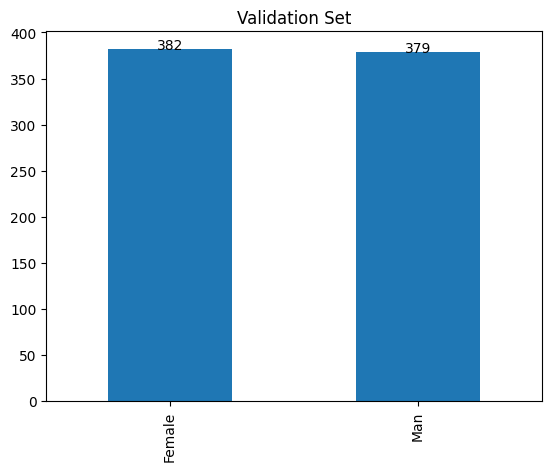

In [89]:
X = df['filename']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y, shuffle=True)

df_train = pd.DataFrame({ 'filename': X_train, 'category': y_train})
df_test = pd.DataFrame({ 'filename': X_test, 'category': y_test})

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

df_train.name = 'Train Set'
df_test.name = 'Validation Set'


for i in [df_train, df_test]:
    i['category'].value_counts().plot(kind='bar', title=i.name)
    for j in range(len(i['category'].value_counts())):
        plt.text(j, i['category'].value_counts()[j], i['category'].value_counts()[j], ha='center')

    plt.show()   

In [90]:
# copy train images to train folder
for index, row in df_train.iterrows():
    filename = row['filename']
    category = row['category']
    src = os.path.join(DATADIR, filename)

    dst = os.path.join(DATADIR, 'train', filename)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

# copy validation images to test folder
for index, row in df_test.iterrows():
    filename = row['filename']
    category = row['category']
    src = os.path.join(DATADIR, filename)

    dst = os.path.join(DATADIR, 'validation', filename)
    if not os.path.exists(dst):
        shutil.copyfile(src, dst)

In [91]:
datagen=ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2,
                            preprocessing_function=preprocess_input)

In [92]:
df_train.head()

,filename,category
0,man.044917.jpg,Man
1,female.004229.jpg,Female
2,man.014114.jpg,Man
3,female.015893.jpg,Female
4,female.020040.jpg,Female


In [93]:
os.path.join(DATADIR, 'train')

'D:\\Study 2018 and later\\Mignimind Bootcamp\\Code\\P5-WarmUp\\Data for all Projects\\celeb_small\\train'

In [94]:
train_generator=datagen.flow_from_dataframe(
                                            dataframe=df_train,
                                            directory=os.path.join(DATADIR, 'train'),
                                            x_col="filename",
                                            y_col="category",
                                            subset="training",
                                            batch_size=32,
                                            seed=SEED,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(178,218))

valid_generator=datagen.flow_from_dataframe(
                                            dataframe=df_train,
                                            directory=os.path.join(DATADIR, 'train'),
                                            x_col="filename",
                                            y_col="category",
                                            subset="validation",
                                            batch_size=32,
                                            seed=SEED,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(178,218))

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
                                                dataframe=df_test,
                                                directory=os.path.join(DATADIR, 'validation'),
                                                x_col="filename",
                                                y_col=None,
                                                batch_size=32,
                                                seed=SEED,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(178,218))

Found 2432 validated image filenames belonging to 2 classes.
Found 608 validated image filenames belonging to 2 classes.
Found 761 validated image filenames.


## 6. Train the Model

- Fit the model
- save the model

In [96]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator, validation_data=valid_generator, 
                    batch_size=32, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VAL,
                    epochs=50,
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/50
76/76 [==============================] - 544s 7s/step - loss: 0.7940 - accuracy: 0.5000 - val_loss: 0.7019 - val_accuracy: 0.5000
Epoch 2/50
76/76 [==============================] - 515s 7s/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6956 - val_accuracy: 0.5000
Epoch 3/50
76/76 [==============================] - 512s 7s/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 4/50
76/76 [==============================] - 512s 7s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 5/50
76/76 [==============================] - 517s 7s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/50
76/76 [==============================] - 513s 7s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/50
76/76 [==============================] - 510s 7s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/50
76

In [97]:
model.save('model-Xception-my-last2-layers.h5')